<h1> 
Investigate users shopping patterns #4

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from mpl_toolkits import mplot3d
from scipy.sparse import csr_matrix
from sklearn.metrics import silhouette_score

In [2]:
orders = pd.read_csv('data/orders.csv')
products = pd.read_csv('data/products.csv')
aisles = pd.read_csv('data/aisles.csv')
prior = pd.read_csv('data/order_products__prior.csv')
train = pd.read_csv('data/order_products__train.csv')
sample = pd.read_csv('data/sample_submission.csv')
departments = pd.read_csv('data/departments.csv')

In [4]:
all_orders = prior.append(train)

merge = pd.merge(all_orders, orders, on='order_id')
merge = merge[['user_id', 'product_id']]
products = products.rename(columns={' product_id': 'product_id'})
merge = pd.merge(merge, products[['product_id', 'product_name', 'aisle_id']], on='product_id')
merge = merge.sort_values('user_id')
user_item = merge[['user_id', 'product_name', 'product_id']][:5000000]

user_item

,user_id,product_name,product_id
18501477,1,Aged White Cheddar Popcorn,26088
19738755,1,Organic String Cheese,25133
19133978,1,Pistachios,10258
22448275,1,Original Beef Jerky,12427
22444847,1,Original Beef Jerky,12427
...,...,...,...
28870517,30588,Orange,23540
5647735,30588,Seedless Red Grapes,4920
20474045,30588,Organic Deep Dark Sea Salt Chocolate,37496
21340747,30588,Organic White Cheddar Popcorn,29370


<h2>1)User-Item matrix

In [5]:
user_item_matrix = user_item.pivot_table(index='user_id', columns='product_name', aggfunc="count")

In [6]:
user_item_matrix = user_item_matrix.fillna(0)

user_item_matrix

product_id                               \
product_name #2 Coffee Filters #2 Cone White Coffee Filters   
user_id                                                       
1                          0.0                          0.0   
2                          0.0                          0.0   
3                          0.0                          0.0   
4                          0.0                          0.0   
5                          0.0                          0.0   
...                        ...                          ...   
30584                      0.0                          0.0   
30585                      0.0                          0.0   
30586                      0.0                          0.0   
30587                      0.0                          0.0   
30588                      0.0                          0.0   

                                                                    \
product_name #2 Mechanical Pencils #4 Natural Brown Coffee Filters   
user_id                                                              
1                              0.0                             0.0   
2                              0.0                             0.0   
3                              0.0                             0.0   
4                              0.0                             0.0   
5                              0.0                             0.0   
...                            ...                             ...   
30584                          0.0                             0.0   
30585                          0.0                             0.0   
30586                          0.0                             0.0   
30587                          0.0                             0.0   
30588                          0.0                             0.0   

                                                     \
product_name & Go! Hazelnut Spread + Pretzel Sticks   
user_id                                               
1                                               0.0   
2                                               0.0   
3                                               0.0   
4                                               0.0   
5                                               0.0   
...                                             ...   
30584                                           0.0   
30585                                           0.0   
30586                                           0.0   
30587                                           0.0   
30588                                           0.0   

                                                            \
product_name (70% Juice!) Mountain Raspberry Juice Squeeze   
user_id                                                      
1                                                      0.0   
2                                                      0.0   
3                                                      0.0   
4                                                      0.0   
5                                                      0.0   
...                                                    ...   
30584                                                  0.0   
30585                                                  0.0   
30586                                                  0.0   
30587                                                  0.0   
30588                                                  0.0   

                                                           \
product_name +Energy Black Cherry Vegetable & Fruit Juice   
user_id                                                     
1                                                     0.0   
2                                                     0.0   
3                                                     0.0   
4                                                     0.0   
5                                                     0.0   
...                         

<hr>

<h2>Minimize User-Item matrix</h2>

<h3>Components=2</h3>

In [7]:
svd = TruncatedSVD(n_components=2, n_iter=5, random_state=None)
mat_reduced = svd.fit_transform(user_item_matrix)
df_mat_reduced = pd.DataFrame(mat_reduced)

df_mat_reduced

,0,1
0,1.306447,-1.260797
1,9.036430,4.329738
2,4.919168,0.874087
3,0.203417,-0.067813
4,1.166331,-0.071361
...,...,...
30583,6.848674,0.658396
30584,0.033234,0.069535
30585,2.845403,-0.492769
30586,24.054719,12.581127


<b>explained_variance_ratio_:</b><br>
Percentage of variance explained by each of the selected components.

If n_components is not set then all components are stored and the sum of the ratios is equal to 1.0.

In [19]:
svd.explained_variance_ratio_.sum()

0.09034821631322364

<h3><i>Result: 9%</i></h3>

<hr>

<h3>Components=3</h3>

In [20]:
svd = TruncatedSVD(n_components=3, n_iter=5, random_state=None)
mat_reduced_3 = svd.fit_transform(user_item_matrix)

mat_reduced_3

array([[ 1.30644683, -1.26075561,  2.56920021],
       [ 9.0364301 ,  4.32969944,  2.12632021],
       [ 4.91916801,  0.87402599, -4.39441683],
       ...,
       [ 2.84540256, -0.4927803 ,  0.17819794],
       [24.05471846, 12.58111657,  2.33979806],
       [ 5.47132809,  2.03195638, -0.41004816]])

In [21]:
svd.explained_variance_ratio_.sum()

0.1023796757788527

<h3><i>Result: 10%</i></h3>

<hr>

<h3>Components=10</h3>

In [7]:
svd = TruncatedSVD(n_components=10, n_iter=5, random_state=None)
mat_reduced_10 = svd.fit_transform(user_item_matrix)

mat_reduced_10

array([[ 1.30644672, -1.26080833,  2.55893268, ...,  2.57219311,
         0.72794924, -0.04311924],
       [ 9.03642998,  4.32971847,  2.12525414, ...,  0.02888114,
         0.72829559,  6.69917195],
       [ 4.91916794,  0.87408337, -4.4008071 , ..., -0.59576965,
        -5.2684682 ,  3.32994219],
       ...,
       [ 2.8454025 , -0.49279189,  0.18577273, ..., -0.16889176,
        -0.80974739, -0.15338392],
       [24.05471862, 12.58110078,  2.34513011, ..., -5.32624069,
         0.23504305, -7.23300736],
       [ 5.47132791,  2.03196837, -0.40690474, ..., -0.07265799,
         1.90897845,  0.9477938 ]])

In [15]:
svd.explained_variance_ratio_.sum()

0.18202830914865786

<h3><i>Result: 18%</i></h3>

<hr>

<h3>Components=20</h3>

In [8]:
svd = TruncatedSVD(n_components=20, n_iter=5, random_state=None)
mat_reduced_20 = svd.fit_transform(user_item_matrix)
mat_reduced_20

array([[ 1.30644669e+00, -1.26081564e+00,  2.56533572e+00, ...,
         1.37260377e+00,  7.92379798e-01, -7.77347284e-01],
       [ 9.03642996e+00,  4.32971715e+00,  2.13080497e+00, ...,
        -9.41592913e-01,  3.13579927e-02, -2.61255663e+00],
       [ 4.91916791e+00,  8.74085558e-01, -4.40386073e+00, ...,
        -8.73400480e-01, -2.10446675e-01,  4.57865512e-01],
       ...,
       [ 2.84540255e+00, -4.92795009e-01,  1.82662128e-01, ...,
        -1.99394373e-02, -6.51930832e-01,  6.64818144e-01],
       [ 2.40547186e+01,  1.25810825e+01,  2.35009598e+00, ...,
        -9.51743926e-01, -1.83236310e+00, -1.95904081e+00],
       [ 5.47132792e+00,  2.03196679e+00, -4.11461854e-01, ...,
        -1.56487715e-01, -9.46698387e-01, -5.99077955e-03]])

In [23]:
svd.explained_variance_ratio_.sum()

0.20131837755921522

<h3><i>Result: 20%</i></h3>

<h3>Components=1000</h3>

In [48]:
svd = TruncatedSVD(n_components=1000, n_iter=5, random_state=None)
mat_reduced_1000 = svd.fit_transform(user_item_matrix)
mat_reduced_1000

array([[ 1.30644669e+00, -1.26081038e+00,  2.56545204e+00, ...,
         1.48014156e-01,  3.50845277e-01, -1.74172782e-01],
       [ 9.03642996e+00,  4.32972031e+00,  2.13063912e+00, ...,
         4.62245009e-01,  2.48440863e-01,  9.44319074e-02],
       [ 4.91916791e+00,  8.74088865e-01, -4.40393014e+00, ...,
         4.57207670e-01, -1.10099422e-01,  9.37746401e-02],
       ...,
       [ 2.84540254e+00, -4.92798217e-01,  1.82671967e-01, ...,
         5.55934629e-03, -2.43835893e-01,  2.19374022e-01],
       [ 2.40547186e+01,  1.25810799e+01,  2.35116054e+00, ...,
         1.74142269e+00, -1.79125961e+00, -5.57695171e-01],
       [ 5.47132792e+00,  2.03196759e+00, -4.10896141e-01, ...,
        -3.16355796e-01, -2.15065732e-01,  1.03407686e-01]])

In [50]:
svd.explained_variance_ratio_.sum()

0.7504200414459443

<h3><i>Result: 75%</i></h3>

<hr>

<h2><i>General chart</i></h2>

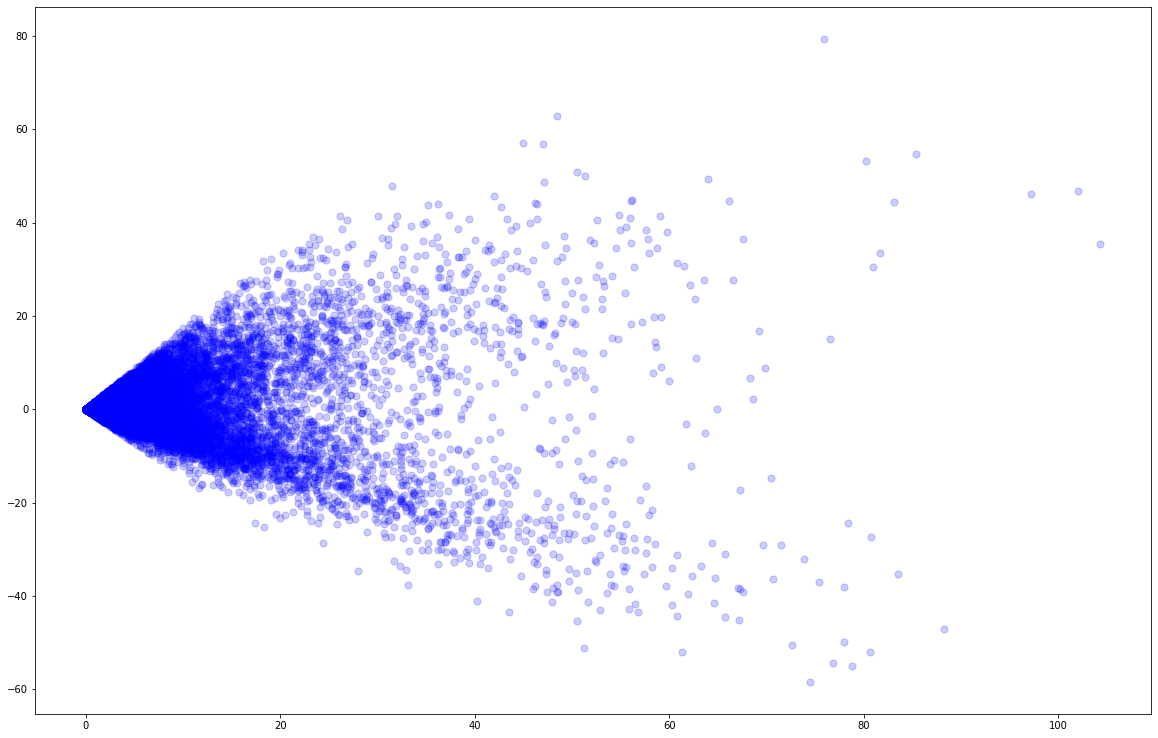

In [31]:
plt.figure(figsize=(20,13))
plt.scatter(mat_reduced[:, 0], mat_reduced[:, 1], c='blue', s=50, cmap='viridis', alpha=0.2)

<hr>

<h2>2)CLUSTERING

<h3> K-Means with 2 components matrix

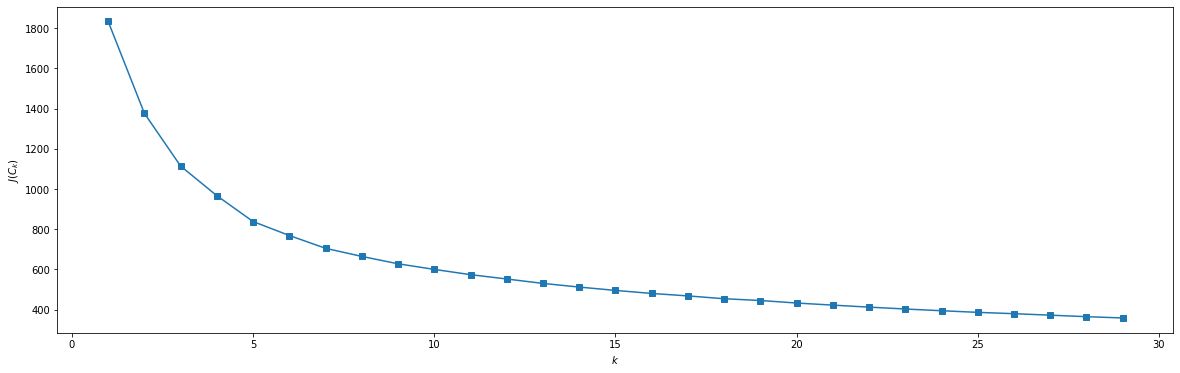

In [98]:
inertia = []
for k in range(1, 30):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(mat_reduced)
    inertia.append(np.sqrt(kmeans.inertia_))

plt.figure(figsize=(20,6))
plt.plot(range(1, 30), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

<h3>Clusters=5</h3>

In [58]:
def res_kmeans(n_clust, mat_reduced):
    kmeans = KMeans(n_clusters=n_clust, random_state=0)

    clusters = kmeans.fit(mat_reduced)
    centers = clusters.cluster_centers_
    y = clusters.labels_

    plt.figure(figsize=(20,13))
    plt.title('Clusters = 5')
    plt.scatter(mat_reduced[:, 0], mat_reduced[:, 1], c=y, s=50, cmap='viridis', alpha=0.2)

    center_users = []
    users_id = []
    colors=['red', 'black', 'blue', 'green', 'yellow']
    for center in centers:
        #find the closest user to the cluster centroid
        user = df_mat_reduced.loc[df_mat_reduced[0]<(center[0]+0.9)]
        user = user.loc[user[0]>(center[0]-0.9)]
        user = user.loc[user[1]<(center[1]+0.9)]
        user = user.loc[user[1]>(center[1]-0.9)][:1]
        user_id = user.index[0]+1
        center_users.append(user.values.tolist()[0])
        users_id.append(user_id)

        plt.scatter(center[0], center[1], c=colors[y[user_id-1]], s=200, alpha=1, label='user_id='+str(user_id))

    plt.legend()
    plt.colorbar()
    plt.clim(0,5)
    return user_id

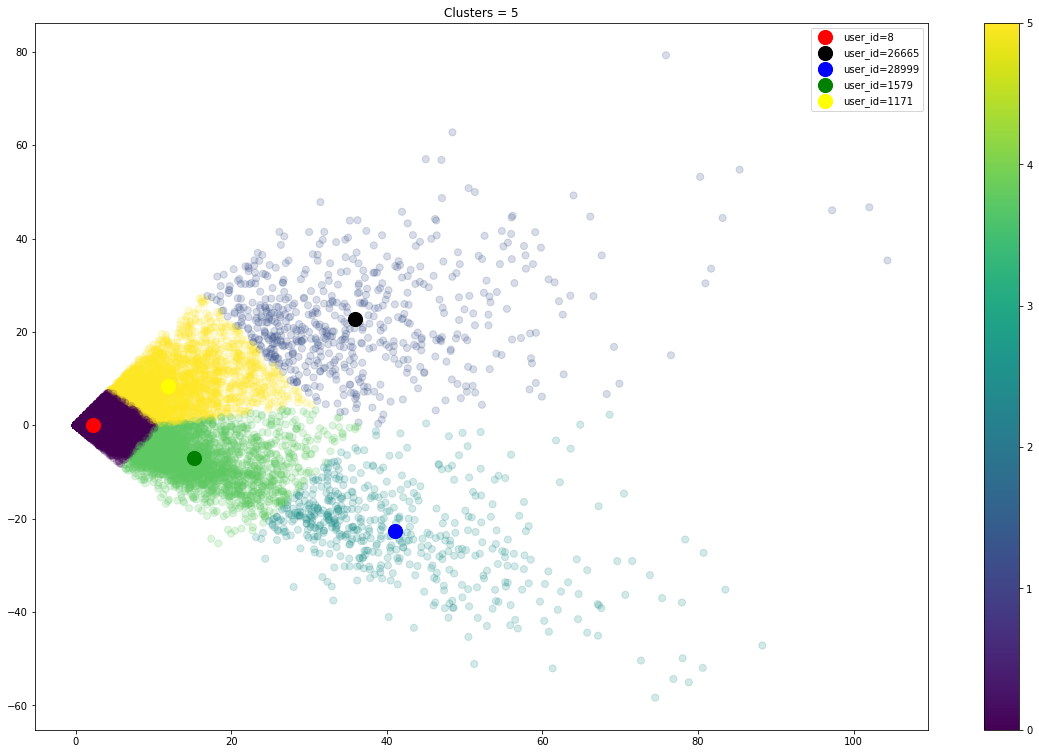

In [37]:
users_id = res_kmeans(5, mat_reduced)

<h3><i>Evaluate the quality of clustering</i></h3>

In [34]:
silhouette_score(mat_reduced, y, metric='euclidean')

0.6614366974972677

<h3><i>Accuracy: 66%</i></h3>

<hr>

<h3>Сluster centroids</h3>

In [333]:
result = pd.DataFrame(center_users)
result['user_id'] = users_id
result

,0,1,user_id
0,2.049277,-0.145401,8
1,41.862665,-23.466433,28999
2,36.530856,21.911345,26665
3,15.264508,-6.288478,1579
4,11.638226,8.020206,1171


<hr>

<h3><b>5 frequently purchased products of each of the found users</b></h3>

<h3><i>User 8</i></h3>

In [43]:
user_orders = user_item.loc[user_item['user_id'] == 8]
user_orders.product_name.value_counts().head(5).to_frame('count')

,count
Organic Leek,4
Carrots,3
Organic Baby Spinach,3
Unsalted Pure Irish Butter,3
Organic Whole White Mushrooms,2


<h3><i>User 28999</i></h3>

In [44]:
user_orders = user_item.loc[user_item['user_id'] == 28999]
user_orders.product_name.value_counts().head(5).to_frame('count')

,count
Organic Milk,30
Organic Raspberries,27
Bag of Organic Bananas,23
Morning Blend 100% Juice,23
Organic Strawberries,22


<h3><i>User 26665</i></h3>

In [40]:
user_orders = user_item.loc[user_item['user_id'] == 26665]
user_orders.product_name.value_counts().head(5).to_frame('count')

,count
Grade A Large Eggs Cage Free Omega 3,27
Organic Avocado,25
Banana,24
Organic Lacinato (Dinosaur) Kale,23
Organic Whole Milk,22


<h3><i>User 1579</i></h3>

In [45]:
user_orders = user_item.loc[user_item['user_id'] == 1579]
user_orders.product_name.value_counts().head(5).to_frame('count')

,count
Uncured Genoa Salami,13
Carrots,11
Organic Strawberries,10
Bag of Organic Bananas,9
Organic String Cheese,9


<h3><i>User 1171</i></h3>

In [46]:
user_orders = user_item.loc[user_item['user_id'] == 1171]
user_orders.product_name.value_counts().head(5).to_frame('count')

,count
Natural Artisan Water,21
Organic Avocado,17
Banana,13
Natural Spring Water,9
Oven Roasted Turkey Breast,7


<h3>Top 5 purchased products for each cluster</h3>

In [21]:
def popular_product(data, cluster_id, clustering_res):
    df_products = pd.DataFrame({'product_name':[]})
    for i in range(len(clustering_res)):
        if clustering_res[i] == cluster_id:
            products = data.loc[data['user_id']==i+1]
            df_products = df_products.append(pd.DataFrame(products))
    return df_products.product_name.value_counts().head(5).to_frame('count')

<h3><i>Cluster_0</i></h3>

In [22]:
popular_product(user_item, 0, y)

,count
Banana,19664
Bag of Organic Bananas,17580
Organic Baby Spinach,12145
Organic Strawberries,11599
Strawberries,10369


<h3><i>Cluster_1</i></h3>

In [23]:
popular_product(user_item, 1, y)

,count
Banana,19363
Organic Strawberries,4609
Organic Baby Spinach,4391
Organic Avocado,4279
Large Lemon,3152


<h3><i>Cluster_2</i></h3>

In [24]:
popular_product(user_item, 2, y)

,count
Bag of Organic Bananas,14037
Organic Hass Avocado,8130
Organic Strawberries,7357
Organic Baby Spinach,5151
Organic Raspberries,5044


<h3><i>Cluster_3</i></h3>

In [25]:
popular_product(user_item, 3, y)

,count
Bag of Organic Bananas,23405
Organic Strawberries,11523
Organic Hass Avocado,11430
Organic Baby Spinach,9773
Organic Raspberries,6711


<h3><i>Cluster_4</i></h3>

In [26]:
popular_product(user_item, 4, y)

,count
Banana,29901
Organic Avocado,6736
Organic Baby Spinach,6174
Large Lemon,5455
Organic Strawberries,5380


<hr>

In [316]:
def plot_kmeans(kmeans, X, n_clusters, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)
    
    plt.figure(figsize=(20,20))
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2, alpha=0.1)
    
    centers = kmeans.cluster_centers_
    ax.scatter(centers[:, 0], centers[:, 1], c='red', s=200)
    radii = [cdist(X[labels == i], [center]).max()
            for i, center in enumerate(centers)]
    
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.3, zorder=0.01))

<h3>Clusters=15</h3>

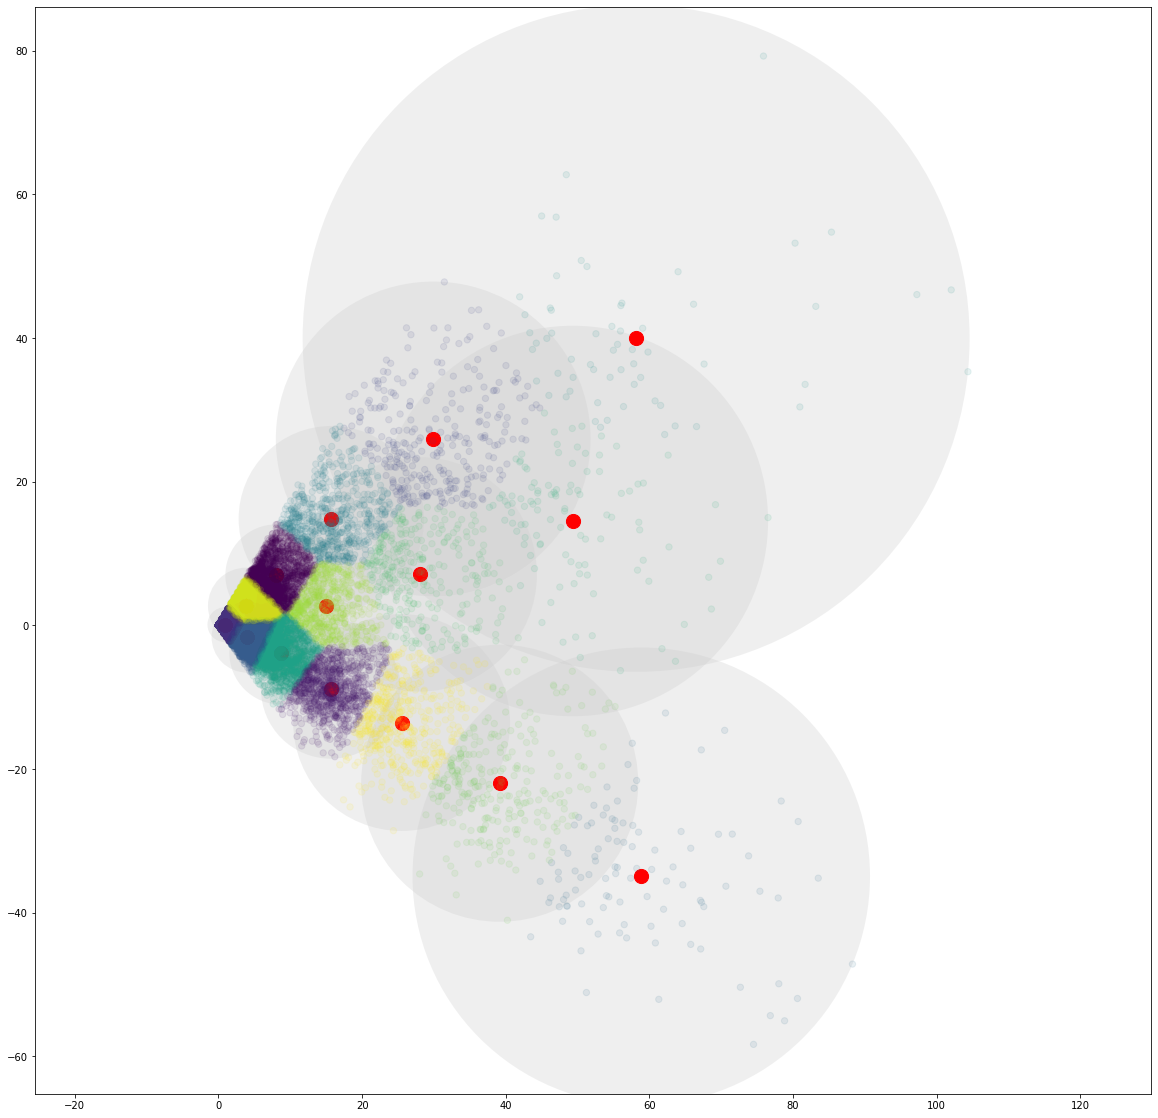

In [317]:
kmeans = KMeans(n_clusters=15, random_state=0)
plot_kmeans(kmeans, mat_reduced, n_clusters=15)

In [63]:
kmeans = KMeans(n_clusters=15, random_state=0).fit(mat_reduced)
silhouette_score(mat_reduced, kmeans.labels_, metric='euclidean')

0.49584855487960744

<h3><i>Accuracy: 50%</i></h3>

<h3><i>Partitioning into 15 clusters is already unnecessary</i></h3>

<hr>

<h3> K-Means with 1000 components matrix

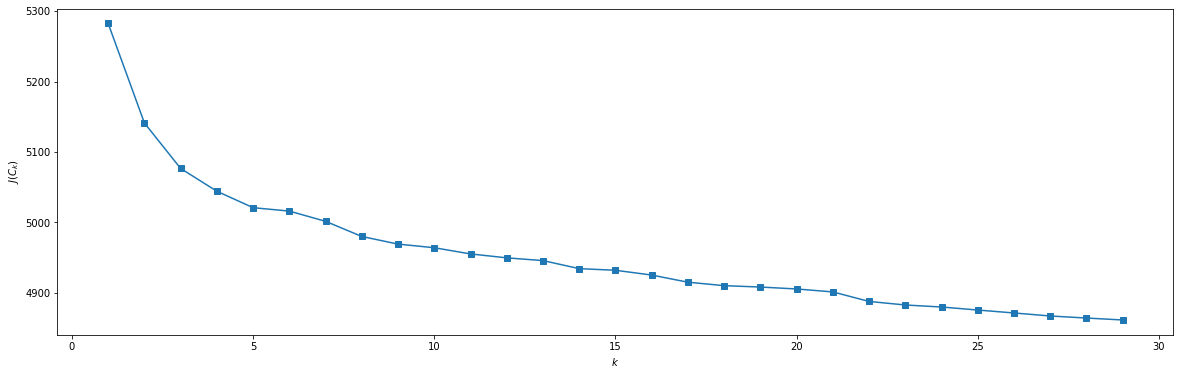

In [54]:
inertia = []
for k in range(1, 30):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(mat_reduced_1000)
    inertia.append(np.sqrt(kmeans.inertia_))

plt.figure(figsize=(20,6))
plt.plot(range(1, 30), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

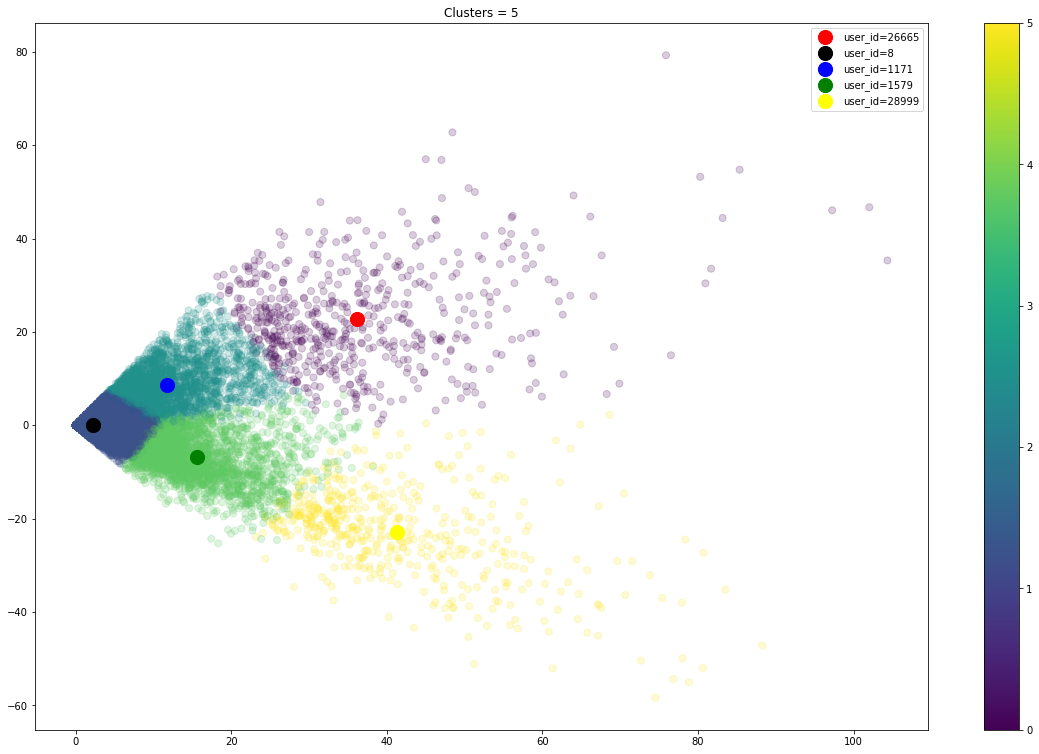

In [59]:
users_id = res_kmeans(5, mat_reduced_1000)

<h3><i>Evaluate the quality of clustering</i></h3>

In [62]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(mat_reduced_1000)
silhouette_score(mat_reduced_1000, kmeans.labels_, metric='euclidean')

0.38903715923335125

<h3><i>Accuracy = 39%</i></h3>